In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
#import xgboost as xgb
#import catboost as cb
%matplotlib inline
pd.set_option('display.max_columns', None)


In [2]:
df_train = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/train_s1/exam_score.csv')
df_test = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/test_s1/submission_s1.csv')
df_test.rename(columns={'pred':'score'},inplace = True)
course_class = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/train_s1/course.csv')
student = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/train_s1/student.csv')
all_know = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/train_s1/all_knowledge.csv')
df_all = df_train.append(df_test)
df_all = df_all.merge(course_class, on='course', how='left')
df_all = df_all.merge(student, on='student_id', how='left')


In [3]:
tmp1 = df_train.groupby(by=['student_id','course'], as_index=False)['score'].agg({'mean_score':np.mean, 
                'median_score':np.median, 'std_score':np.std,'max_score':np.max,'min_score':np.min, 
                'pip_score':np.ptp})


tmp2 = df_train.groupby(by=['student_id'], as_index=False)['score'].agg({'s_mean_score':np.mean, 
                's_median_score':np.median, 's_std_score':np.std,'s_max_score':np.max,'min_score':np.min,
                's_pip_score':np.ptp})


/home/wjunneng/Python/anaconda3/envs/lightgbm/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [4]:
df_all=df_all.merge(tmp1, on=['student_id','course'], how='left')
df_all=df_all.merge(tmp2, on=['student_id'], how='left')


In [5]:
course1_exam = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/train_s1/course1_exams.csv')
course2_exam = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/train_s1/course2_exams.csv')
course3_exam = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/train_s1/course3_exams.csv')
course4_exam = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/train_s1/course4_exams.csv')
course5_exam = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/train_s1/course5_exams.csv')
course6_exam = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/train_s1/course6_exams.csv')
course7_exam = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/train_s1/course7_exams.csv')
course8_exam = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/train_s1/course8_exams.csv')
#col_c1 = [i for i in course1_exam.columns if i not in ['course','exam_id']]
tmp4=1
for i in [course1_exam,course2_exam,course3_exam,course4_exam,course5_exam,course6_exam,course7_exam,course8_exam]:
    name = i
    col_c1 = [i for i in name.columns if i not in ['course','exam_id']]
    name['course'] ='course'+str(tmp4)
    tmp2 =np.array(all_know.loc[all_know['course'] == ('course'+str(tmp4)),:]['complexity'])
    tmp = name[col_c1]
    tmp3 =np.dot(tmp.values,tmp2)
    name['hard'] = tmp3
    name['hard_inverse'] = name['hard'].apply(lambda x:1/(x+1e-10))
    tmp4 = tmp4+1

course_exam = course1_exam.append(course2_exam)
course_exam = course_exam.append(course3_exam)
course_exam = course_exam.append(course4_exam)
course_exam = course_exam.append(course5_exam)
course_exam = course_exam.append(course6_exam)
course_exam = course_exam.append(course7_exam)
course_exam = course_exam.append(course8_exam)
course_exam.fillna(0,inplace = True)


/home/wjunneng/Python/anaconda3/envs/lightgbm/lib/python3.6/site-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [6]:
sub_course_exam = course_exam[['course','exam_id','hard','hard_inverse']]


In [7]:
df_all.shape


(73500, 18)

In [8]:
df_all=df_all.merge(sub_course_exam, on=['exam_id','course'], how='left')


In [9]:
df_all.shape


(73500, 20)

In [10]:
for i in ['course','course_class','exam_id','student_id']:
    lbl = LabelEncoder()
    #all_data[i+"_count"] = all_data.groupby([i])[i].transform('count')
    #all_data[i+"_rank"] = all_data[i+"_count"].rank(method='min')
    df_all[i] = lbl.fit_transform(df_all[i].astype(str))


In [11]:
df_train = df_all[:65500]
df_test = df_all[65500:].reset_index(drop=True)
col = [i for i in df_all.columns if i not in ['score']]
X_train = df_train[col]
y = df_train['score']


In [12]:
X_train.head()


,student_id,course,exam_id,course_class,gender,mean_score,median_score,std_score,max_score,min_score_x,pip_score,s_mean_score,s_median_score,s_std_score,s_max_score,min_score_y,s_pip_score,hard,hard_inverse
0,80,0,118,0,0,82.611111,82.5,8.395649,98,67,31,76.290076,77,9.713186,98,0,98,175,0.005714
1,48,0,118,0,0,78.222222,77.5,4.037407,88,71,17,86.068702,86,7.208105,100,71,29,175,0.005714
2,217,0,118,0,0,80.666667,80.0,7.483315,96,66,30,80.511450,81,6.476426,96,66,30,175,0.005714
3,329,0,118,0,1,82.555556,82.0,5.124591,92,76,16,88.847328,90,7.665581,100,68,32,175,0.005714
4,237,0,118,0,0,80.055556,80.0,4.398826,89,71,18,82.129771,83,12.204915,99,0,99,175,0.005714


In [13]:
from xgboost import XGBRegressor

test_y = np.zeros(len(df_test))
random_seed = 2019
cv_model = []
cv_score = []
skf = StratifiedKFold(n_splits=5, random_state=random_seed, shuffle=True)
for index, (train_index, test_index) in enumerate(skf.split(X_train, y)):
    #print(index)
    train_x, val_x, train_y, val_y = X_train.iloc[train_index], X_train.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    xgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'reg:linear',
        'n_estimators': 10000,
        #'metric': 'mae',
        'learning_rate': 0.01,
        'min_child_samples': 46,
        'min_child_weight': 0.01,
        'subsample_freq': 1,
        'num_leaves': 40,
        'max_depth': 7,
        'subsample': 0.42,
        'colsample_bytree': 0.48,
        'reg_alpha': 0.15,
        'reg_lambda': 5,
        'verbose': -1,
        'seed': 4590
    }
    xgb = XGBRegressor(**xgb_params)


    xgb.fit(
        train_x,
        train_y,
        eval_set=[(train_x, train_y), (val_x, val_y)],
        # eval_names=['train', 'val'],
        eval_metric='rmse',
        #eval_metric = evaluate_macroF1_lgb, 
        early_stopping_rounds=100,
        verbose = True,
    )
    cv_model.append(xgb)
    xgb.n_estimators = xgb.best_iteration
    val_y_pred = xgb.predict(val_x)
    cv_score.append( np.sqrt(mean_squared_error(val_y,val_y_pred)))
    test_y += xgb.predict(df_test[col])/5
print("CV score: ",np.mean(cv_score))


[20:17:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:82.146	validation_1-rmse:82.1357
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:81.3336	validation_1-rmse:81.3235
[2]	validation_0-rmse:80.5262	validation_1-rmse:80.5164
[3]	validation_0-rmse:79.7272	validation_1-rmse:79.718
[4]	validation_0-rmse:78.9373	validation_1-rmse:78.928
[5]	validation_0-rmse:78.1547	validation_1-rmse:78.1456
[6]	validation_0-rmse:77.3805	validation_1-rmse:77.3717
[7]	validation_0-rmse:76.6136	validation_1-rmse:76.6052
[8]	validation_0-rmse:75.855	validation_1-rmse:75.8473
[9]	validation_0-rmse:75.1031	validation_1-rmse:75.0952
[10]	validation_0-rmse:74.359	validation_1-rmse:74.3514
[11]	validation_0-rmse:73.6225	validation_1-rmse:73.6153
[12]	validation_0-rmse:72.8936	validation_1-

/home/wjunneng/Python/anaconda3/envs/lightgbm/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/wjunneng/Python/anaconda3/envs/lightgbm/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/wjunneng/Python/anaconda3/envs/lightgbm/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/wjunneng/Python/anaconda3/envs/lightgbm/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/wjun

In [14]:
test_y


array([81.23517036, 77.71175194, 79.38261318, ..., 75.7492981 ,
       70.93831158, 70.06633377])

In [15]:
sub_test = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/test_s1/submission_s1.csv')


In [16]:
sub_test['pred'] = test_y


In [17]:
sub_test


,student_id,course,exam_id,pred
0,230748,course1,m31I6cTD,81.235170
1,186851,course1,m31I6cTD,77.711752
2,478370,course1,m31I6cTD,79.382613
3,692328,course1,m31I6cTD,82.160439
4,509128,course1,m31I6cTD,79.159658
5,604234,course1,m31I6cTD,96.481342
6,992922,course1,m31I6cTD,77.971545
7,488841,course1,m31I6cTD,90.867441
8,831322,course1,m31I6cTD,80.559206
9,940245,course1,m31I6cTD,76.834986


In [18]:
sub_test.to_csv('/home/wjunneng/Python/ForecastScore/data/test_s1/submission_s1_sample_baseline_1.csv',index=None)


[              name     score
0       student_id  0.011111
1           course  0.011986
2          exam_id  0.018901
3     course_class  0.010878
4           gender  0.011783
5       mean_score  0.246295
6     median_score  0.209631
7        std_score  0.021774
8        max_score  0.106918
9      min_score_x  0.131262
10       pip_score  0.018140
11    s_mean_score  0.027588
12  s_median_score  0.039589
13     s_std_score  0.012503
14     s_max_score  0.041984
15     min_score_y  0.010349
16     s_pip_score  0.012835
17            hard  0.028070
18    hard_inverse  0.028402,               name     score
0       student_id  0.010170
1           course  0.012320
2          exam_id  0.018065
3     course_class  0.008672
4           gender  0.012711
5       mean_score  0.255960
6     median_score  0.219880
7        std_score  0.021102
8        max_score  0.094315
9      min_score_x  0.132357
10       pip_score  0.017965
11    s_mean_score  0.042864
12  s_median_score  0.025056
13     s_std

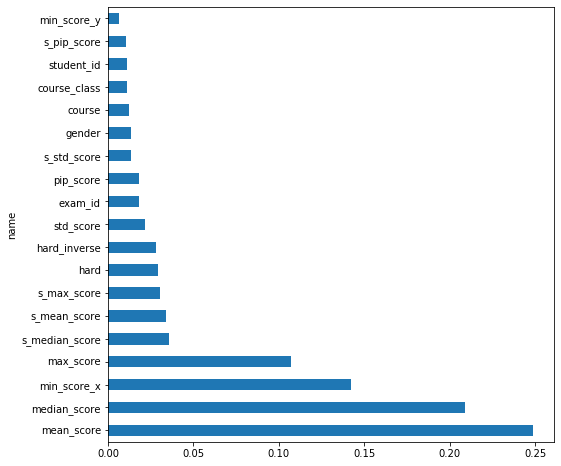

In [19]:
fi = []
for i in cv_model:
    tmp = {
        'name' : col,
        'score' : i.feature_importances_
    }
    fi.append(pd.DataFrame(tmp))

print(fi)    
fi = pd.concat(fi)
fig = plt.figure(figsize=(8,8))
fi.groupby(['name'])['score'].agg('mean').sort_values(ascending=False).head(40).plot.barh()